# Train classifiers

This notebook will use the training dataset created by notebook `00c` to train the PU and SVM models.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

In [1]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Random seed for reproducibility
random_seed = 1234

# Number of processes to use
n_jobs = 4

# Overwrite any existing output files
overwrite = True

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [2]:
import os

from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

output_dir = "outputs"

If any of the following exist as environment variables, they will replace the values defined above:

In [3]:
random_seed = int(os.environ.get("RANDOM_SEED", random_seed))
n_jobs = int(os.environ.get("N_JOBS", n_jobs))
overwrite = bool(int(os.environ.get("OVERWRITE", overwrite)))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))
output_dir = os.environ.get("OUTPUT_DIR", output_dir)

## Notebook setup

Imports, definitions, etc.

### Imports

In [4]:
import time
import warnings
from datetime import timedelta

import cartopy.crs as ccrs
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.gridliner import (
    LATITUDE_FORMATTER,
    LONGITUDE_FORMATTER,
)
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from pulearn.bagging import BaggingPuClassifier
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from sklearn.base import clone
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import IterativeImputer
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline,
)
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from lib.check_files import check_prepared_data
from lib.feature_selection import (
    dendrogram_from_model,
    distance_threshold_from_model,
)
from lib.misc import (
    format_feature_name,
)
from lib.pu import (
    PU_PARAMS,
    COLUMNS_TO_DROP,
    PRESERVATION_COLUMNS,
    Scorer,
    downsample_unlabelled,
)

# Suppress FutureWarning for some versions of pandas
pd.set_option('future.no_silent_downcasting', True)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore

# Drop individual water/carbon components, only use totals
component_columns = {
    "base_lithosphere_water_thickness (m)",
    "sedimentary_bound_water_thickness (m)",
    "sedimentary_pore_water_thickness (m)",
    "mantle_lithosphere_water_thickness (m)",
    "crustal_pore_water_thickness (m)",
    "crustal_bound_water_thickness (m)",
    "subducted_carbonate_volume (m)",
    "carbonate_carbon_density (t/m^2)",
    "carbonate_thickness (m)",
    "crustal_carbon_density (t/m^2)",
}

env: PYTHONWARNINGS=ignore


### Input and output files

In [5]:
data_filename = os.path.join(data_dir, "training_data_global.csv")

output_dir = os.path.join(output_dir, "global")
os.makedirs(output_dir, exist_ok=True)
output_deposits = os.path.join(output_dir, "deposits")
figures_dir = os.path.join(output_dir, "feature_selection")
os.makedirs(figures_dir, exist_ok=True)

pu_dir = os.path.join(output_dir, "PU")
os.makedirs(pu_dir, exist_ok=True)
pu_cv_basename = os.path.join(pu_dir, "cv_results")
pu_basename = os.path.join(pu_dir, "classifier")

svm_dir = os.path.join(output_dir, "SVM")
os.makedirs(svm_dir, exist_ok=True)
svm_cv_basename = os.path.join(svm_dir, "cv_results")
svm_basename = os.path.join(svm_dir, "classifier")

### Model parameters

In [6]:
# Parameters for models
imputer_params = {
    "random_state": random_seed,
    "add_indicator": False,
}
rf_params = {
    "random_state": random_seed,
    "n_estimators": 50,
    "n_jobs": 1,
}
pu_params = {
    **PU_PARAMS,
    "n_jobs": n_jobs,
    "random_state": random_seed,
    "n_estimators": 50,
}
svm_params = {
    "kernel": "rbf",
    "probability": True,
    "random_state": random_seed,
}

Define model and preprocessing pipeline:

In [7]:
pu_model = BaggingPuClassifier(
    RandomForestClassifier(**rf_params),
    **pu_params
)
preprocessing = make_pipeline(
    IterativeImputer(**imputer_params),
    RobustScaler(),
    VarianceThreshold(),
)
pu_pipeline = Pipeline([("preprocessing", preprocessing), ("classifier", pu_model)])
pu_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('iterativeimputer',
                                  IterativeImputer(random_state=1234)),
                                 ('robustscaler', RobustScaler()),
                                 ('variancethreshold', VarianceThreshold())])),
                ('classifier',
                 BaggingPuClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                                      n_jobs=1,
                                                                      random_state=1234),
                                     n_estimators=50, n_jobs=4,
                                     random_state=1234))])

## Training data

These cells load and plot the training data.

In [8]:
data = pd.read_csv(data_filename)

# Skip regions with < 50 deposits
regions_to_skip = set()
for region, subset in data.groupby("region"):
    if (subset["label"] == "positive").sum() < 50:
        regions_to_skip.add(region)
data = data[~data["region"].isin(regions_to_skip)]

# Equal number of positive and unlabelled samples
negatives = data[data["label"] == "negative"]
tmp = data[data["label"] != "negative"]
tmp_downsampled = downsample_unlabelled(
    tmp,
    random_state=random_seed,
)
combined = pd.concat((tmp_downsampled, negatives))
cleaned = combined.drop(
    columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS | component_columns),
    errors="ignore",
)
del tmp, tmp_downsampled

print("Training data summary:")
print(combined.groupby(["region", "label"]).size())

Training data summary:
region          label     
North America   negative        45
                positive       257
                unlabelled     166
South America   negative      1096
                positive       211
                unlabelled     116
Southeast Asia  negative         4
                positive        55
                unlabelled     163
Tethys          negative        20
                positive        61
                unlabelled     139
dtype: int64


### Deposit locations plot

This cell plots the locations of the deposits in the training dataset, saving the image in the `output_dir` directory.

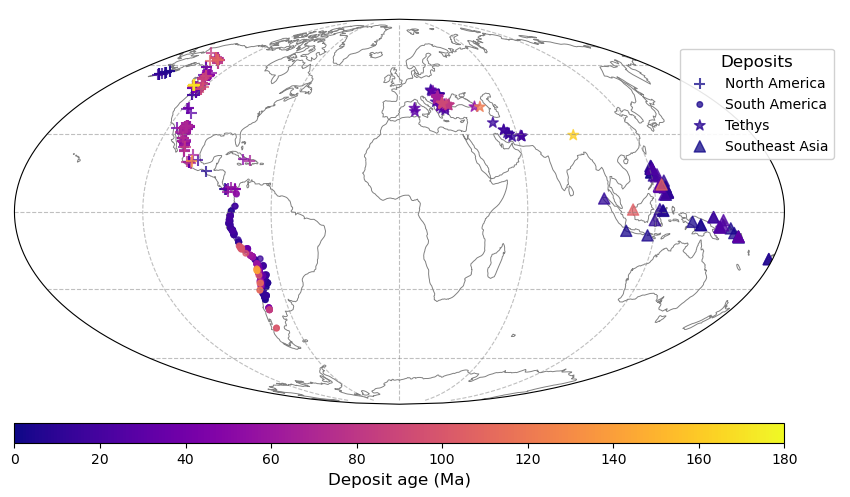

In [9]:
deposits = data[data["label"] == "positive"]

projection = ccrs.Mollweide()
transform = ccrs.PlateCarree()

markers = {
    "North America": "+",
    "South America": ".",
    "Tethys": "*",
    "Southeast Asia": "^",
}
vmin, vmax = 0, 180
cmap = "plasma"
mappable = ScalarMappable(Normalize(vmin, vmax), cmap=cmap)

fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={"projection": projection},
)
ax.set_global()
gl = ax.gridlines(
    draw_labels=False,
    xformatter=LONGITUDE_FORMATTER,
    yformatter=LATITUDE_FORMATTER,
    linestyle="dashed",
    linewidth=0.8,
    alpha=0.5,
    color="grey",
)
cax = fig.add_axes(
    [
        ax.get_position().x0,
        ax.get_position().y0 * 0.3,
        ax.get_position().width,
        ax.get_position().height * 0.05,
    ]
)
for region, marker in markers.items():
    subset = deposits[deposits["region"] == region]
    scat = ax.scatter(
        "present_lon",
        "present_lat",
        c="age (Ma)",
        data=subset,
        marker=marker,
        s=65,
        alpha=0.75,
        transform=transform,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        label=region,
    )
ax.coastlines(zorder=0, color="grey", linewidth=0.7)
cbar = fig.colorbar(
    mappable,
    cax=cax,
    orientation="horizontal",
)
cbar.ax.set_xlabel("Deposit age (Ma)", fontsize=12)
cbar.ax.tick_params(labelsize=10)
fig.legend(
    title="Deposits",
    loc=(0.8, 0.68),
    framealpha=0.9,
    fontsize=10,
    title_fontsize=12,
)

for ext in (".pdf", ".png"):
    fig.savefig(output_deposits + ext, dpi=400, bbox_inches="tight")

## Train the PU models

In the following cells, the positive-unlabelled models are created and trained.

### Global dataset

#### Wrangle training data

In [10]:
# Wrangle the training data to the required format
train_pu = cleaned[cleaned["label"].isin({"positive", "unlabelled"})]
x_pu = train_pu.drop(columns="label")
y_pu = train_pu["label"].replace({"positive": 1, "unlabelled": 0}).astype("int")

### Feature selection

We consider features with a Spearman's correlation $|r| \geq 0.8$ to be highly correlated and remove them.

In [11]:
cutoff_value = 0.8
cluster_threshold = 1 - cutoff_value

Z = linkage(
    clone(preprocessing).fit_transform(x_pu).T,
    method="single",
    metric=lambda x, y: 1.0 - np.abs(spearmanr(x, y).statistic),
)

cluster_ids = fcluster(Z, cluster_threshold, criterion="distance")
clusters = {
    cluster_id: list(x_pu.columns[cluster_ids == cluster_id])
    for cluster_id in np.unique(cluster_ids)
}

#### Dendrogram

This can be illustrated using a dendrogram:

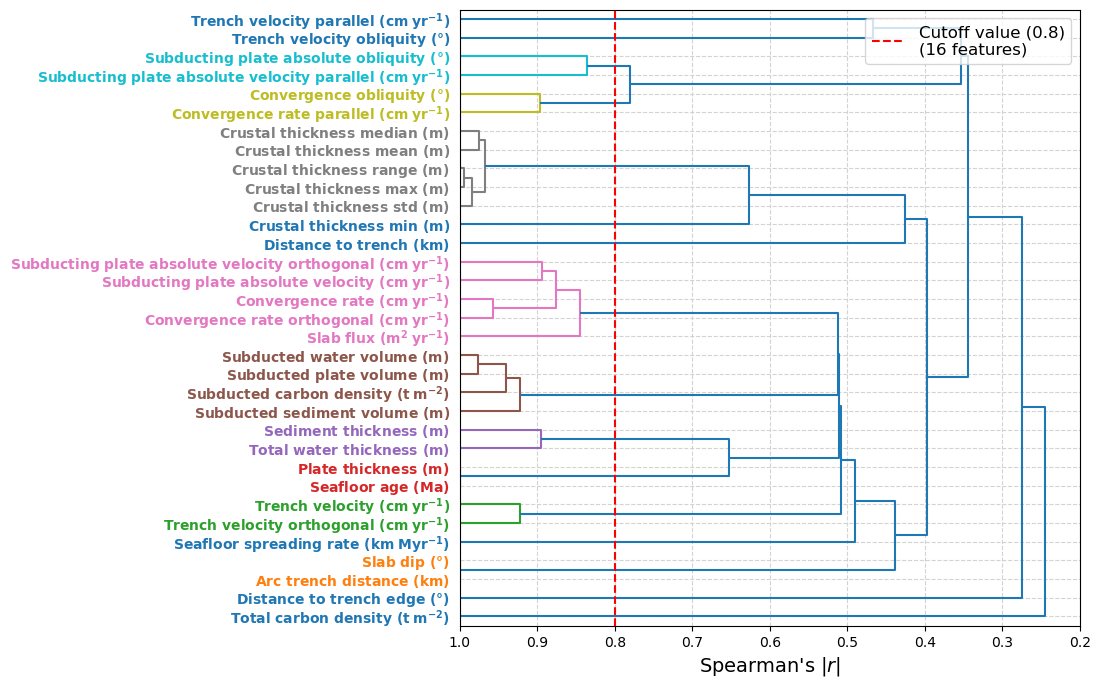

In [12]:
dendrogram_filename = os.path.join(figures_dir, "dendrogram")

fig, ax = plt.subplots(figsize=(8, 8))
dendro = dendrogram(
    Z,
    orientation="right",
    labels=[format_feature_name(i, bold=True) for i in x_pu.columns],
    ax=ax,
    color_threshold=cluster_threshold,
)
ax.axvline(
    cluster_threshold,
    linestyle="dashed",
    color="red",
    zorder=10,
    label=f"Cutoff value ({cutoff_value:0.1f})\n({len(clusters)} features)",
)
ax.grid(linestyle="dashed", color="lightgrey")
ax.set_xticks(ax.get_xticks(), [f"{1 - i:0.1f}" for i in ax.get_xticks()])
ax.set_xlabel(r"Spearman's $|r|$", fontsize=14)
ax.tick_params(labelsize=10)
for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
    i.set_color(j)
    i.set_fontweight("bold")
ax.legend(loc="best", fontsize=12)

for ext in (".pdf", ".png"):
    fig.savefig(dendrogram_filename + ext, dpi=350, bbox_inches="tight")

The following groups of features are highly correlated:

In [13]:
for cluster_id in sorted(clusters.keys()):
    cluster_features = clusters[cluster_id]
    print(f"Cluster #{cluster_id}:")
    for feature in cluster_features:
        print(f"  - {feature}")

Cluster #1:
  - arc_trench_distance (km)
  - slab_dip (degrees)
Cluster #2:
  - trench_velocity_orthogonal (cm/yr)
  - trench_velocity (cm/yr)
Cluster #3:
  - seafloor_age (Ma)
  - plate_thickness (m)
Cluster #4:
  - total_water_thickness (m)
  - sediment_thickness (m)
Cluster #5:
  - subducted_plate_volume (m)
  - subducted_carbon_density (t/m^2)
  - subducted_water_volume (m)
  - subducted_sediment_volume (m)
Cluster #6:
  - subducting_plate_absolute_velocity (cm/yr)
  - slab_flux (m^2/yr)
  - convergence_rate_orthogonal (cm/yr)
  - subducting_plate_absolute_velocity_orthogonal (cm/yr)
  - convergence_rate (cm/yr)
Cluster #7:
  - seafloor_spreading_rate (km/Myr)
Cluster #8:
  - crustal_thickness_mean (m)
  - crustal_thickness_max (m)
  - crustal_thickness_median (m)
  - crustal_thickness_std (m)
  - crustal_thickness_range (m)
Cluster #9:
  - crustal_thickness_min (m)
Cluster #10:
  - distance_to_trench (km)
Cluster #11:
  - convergence_rate_parallel (cm/yr)
  - convergence_obliquity

We can also visualise the number of features as a function of the Spearman's $|r|$ cutoff threshold:

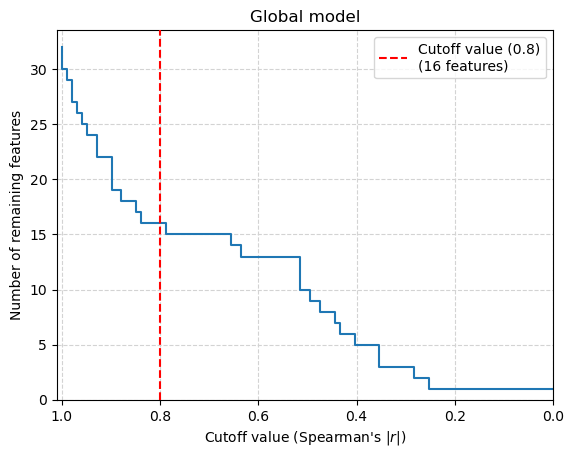

In [14]:
cutoff_nfeatures_filename = os.path.join(figures_dir, "cutoff_nfeatures")

thresh_vals = np.linspace(0, 1, 100)
thresh_clusters = np.array([
    len(np.unique(fcluster(Z, 1 - t, criterion="distance")))
    for t in thresh_vals
])

fig, ax = plt.subplots()
ax.step(thresh_vals, thresh_clusters, where="post")
ax.axvline(
    cutoff_value,
    linestyle="dashed",
    color="red",
    zorder=10,
    label=f"Cutoff value ({cutoff_value:0.1f})\n({len(clusters)} features)",
)
ax.set_xlim(thresh_vals.max() * 1.01, thresh_vals.min())
ax.set_ylim(0, None)
ax.grid(linestyle="dashed", color="lightgrey")
ax.legend(loc="best")
ax.set_xlabel(r"Cutoff value (Spearman's $|r|$)")
ax.set_ylabel("Number of remaining features")
ax.set_title("Global model")

for ext in (".pdf", ".png"):
    fig.savefig(cutoff_nfeatures_filename + ext, dpi=350, bbox_inches="tight")

Now that we know which groups of features are highly correlated, we can select one feature from each group, either manually or automatically.

In [15]:
automatic_feature_selection = False

if automatic_feature_selection:
    selected_features = [
        clusters[cluster_id][0]
        for cluster_id in sorted(np.unique(cluster_ids))
    ]
else:
    selected_features = [
        "convergence_rate_parallel (cm/yr)",
        "subducting_plate_absolute_velocity_parallel (cm/yr)",
        "trench_velocity_obliquity (degrees)",
        "trench_velocity_parallel (cm/yr)",
        "slab_dip (degrees)",
        "trench_velocity_orthogonal (cm/yr)",
        "seafloor_age (Ma)",
        "sediment_thickness (m)",
        "subducted_sediment_volume (m)",
        "convergence_rate_orthogonal (cm/yr)",
        "seafloor_spreading_rate (km/Myr)",
        "crustal_thickness_mean (m)",
        "crustal_thickness_min (m)",
        "distance_to_trench (km)",
        "total_carbon_density (t/m^2)",
        "distance_to_trench_edge (degrees)",
    ]
print(f"Selected {len(selected_features)} features:")
for f in selected_features:
    print(f"  - {f}")

Selected 16 features:
  - convergence_rate_parallel (cm/yr)
  - subducting_plate_absolute_velocity_parallel (cm/yr)
  - trench_velocity_obliquity (degrees)
  - trench_velocity_parallel (cm/yr)
  - slab_dip (degrees)
  - trench_velocity_orthogonal (cm/yr)
  - seafloor_age (Ma)
  - sediment_thickness (m)
  - subducted_sediment_volume (m)
  - convergence_rate_orthogonal (cm/yr)
  - seafloor_spreading_rate (km/Myr)
  - crustal_thickness_mean (m)
  - crustal_thickness_min (m)
  - distance_to_trench (km)
  - total_carbon_density (t/m^2)
  - distance_to_trench_edge (degrees)


#### Train model with selected features

The model will be written to a `.joblib` file in the output directory.

In [16]:
pu_pipeline.fit(x_pu[selected_features], y_pu)
_ = joblib.dump(pu_pipeline, pu_basename + ".joblib", compress=True)

### Regional models

Region: North America
label
positive      257
unlabelled    166
dtype: int64
Region: South America
label
positive      211
unlabelled    116
dtype: int64
Region: Southeast Asia
label
positive       55
unlabelled    163
dtype: int64
Region: Tethys
label
positive       61
unlabelled    139
dtype: int64


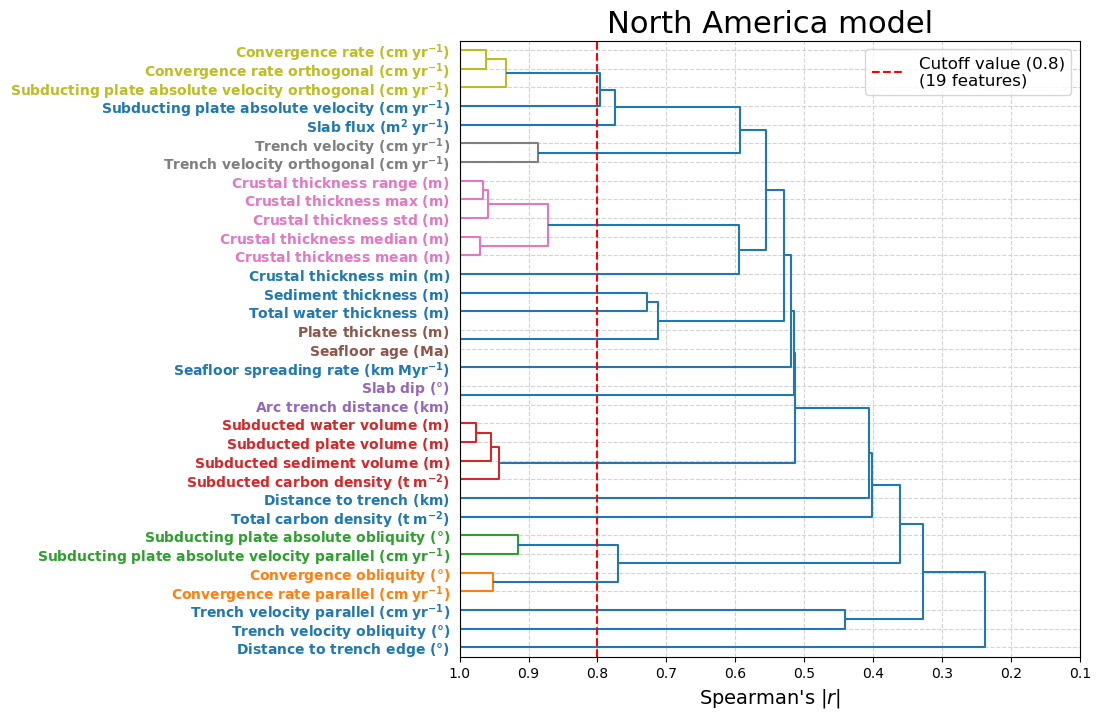

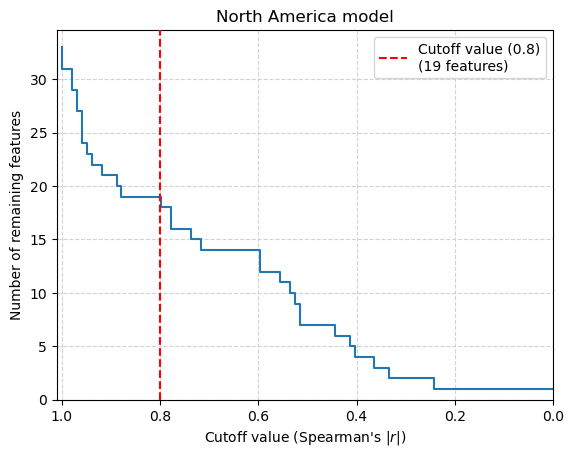

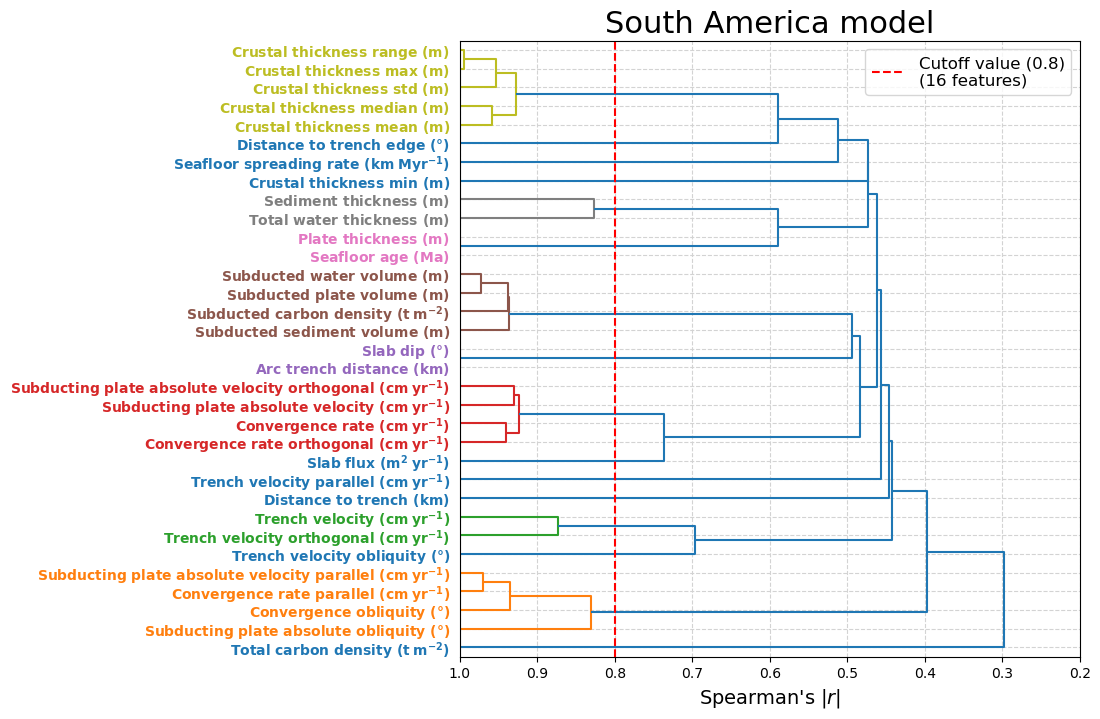

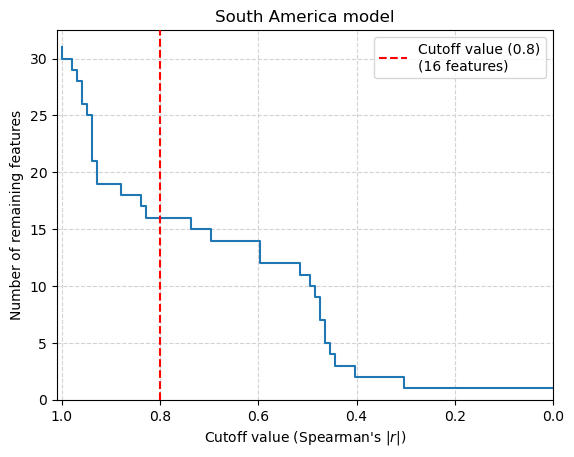

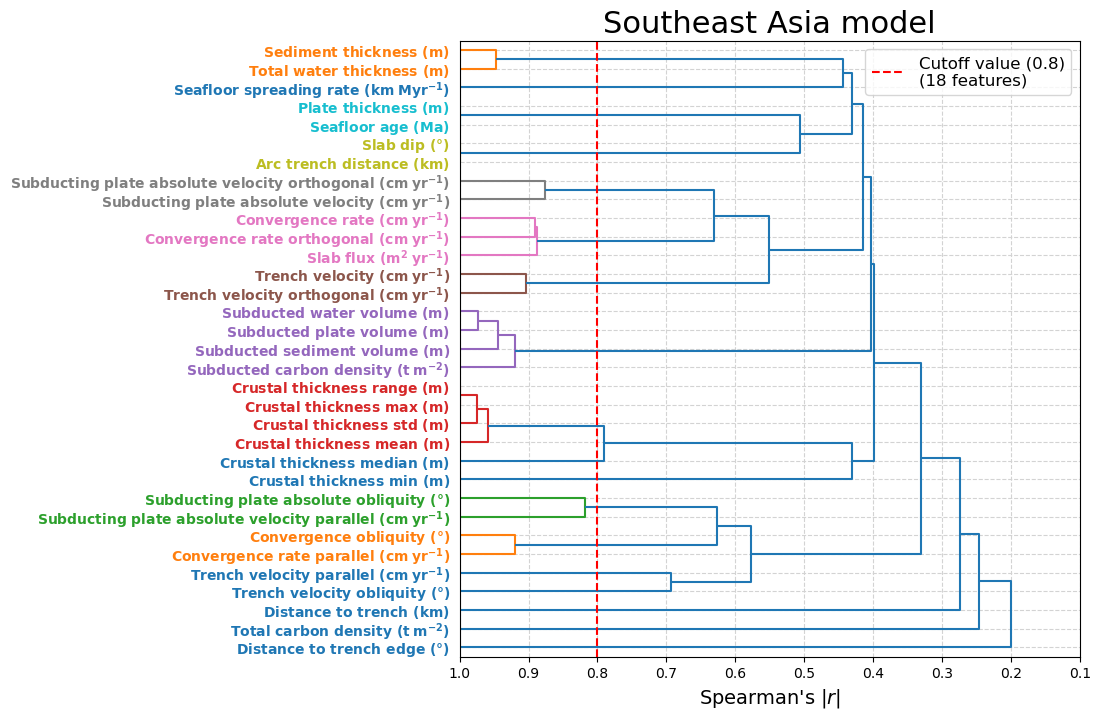

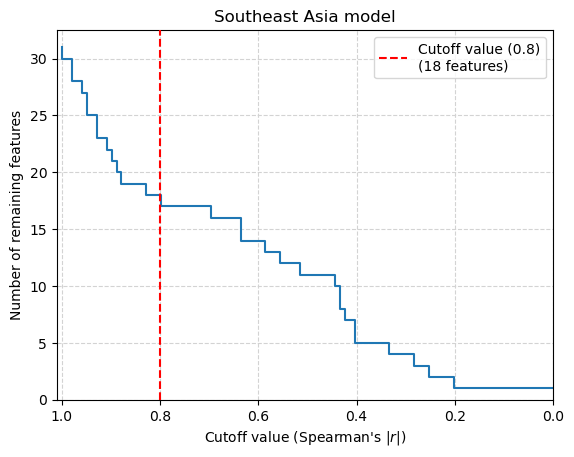

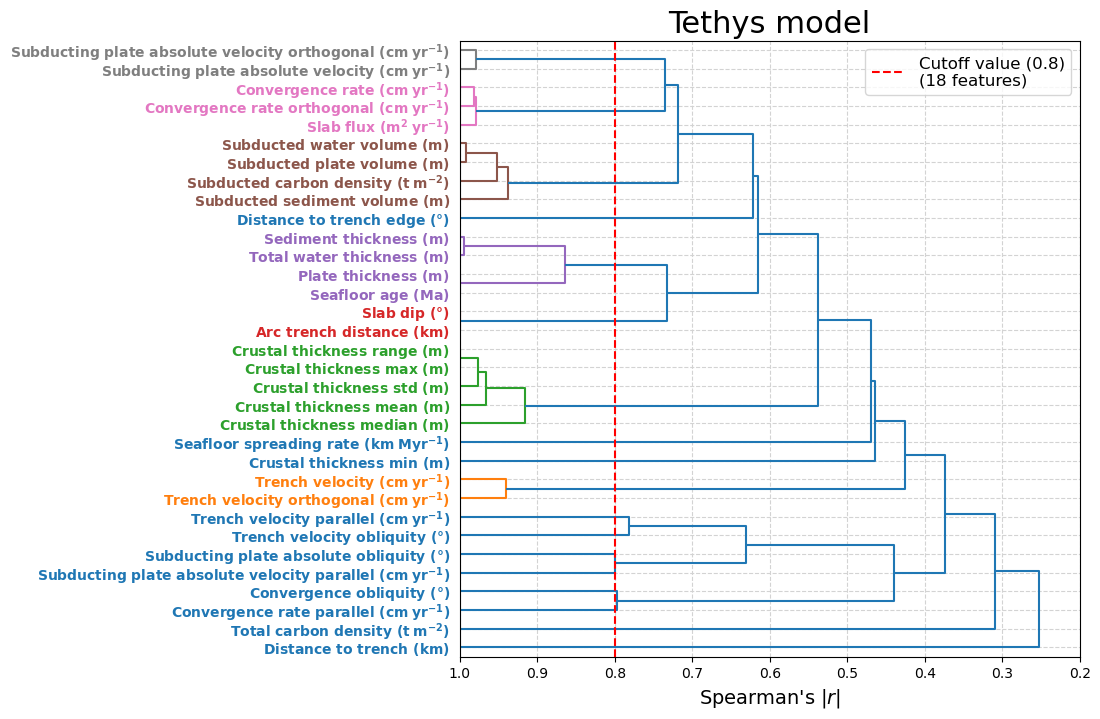

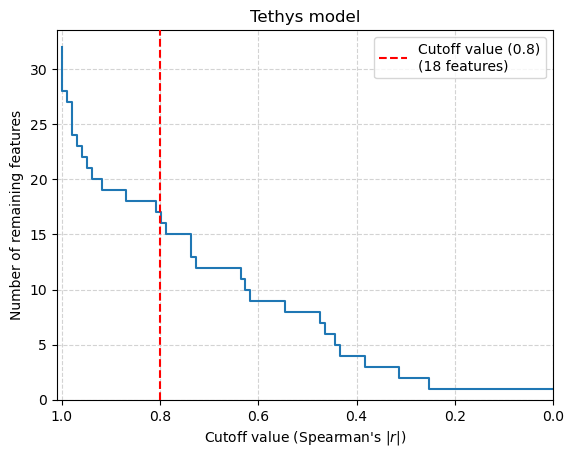

In [17]:
clusters_regions = {}
for region, subset in combined.groupby("region"):
    region = str(region)
    if (subset["label"] == "positive").sum() < 50:
        print(f"Skipping region: {region}")
        continue
    subset = subset.drop(
        columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS | component_columns),
        errors="ignore",
    )
    r = "_".join(region.lower().split())

    print(f"Region: {region}")
    subset = subset[subset["label"].isin({"positive", "unlabelled"})]
    print(subset.groupby("label").size())
    x_pu_subset = subset.drop(columns="label")
    y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0}).astype("int")

    Z_subset = linkage(
        clone(preprocessing).fit_transform(x_pu_subset).T,
        method="single",
        metric=lambda x, y: 1.0 - np.abs(spearmanr(x, y).statistic),
    )

    cluster_ids_subset = fcluster(Z_subset, cluster_threshold, criterion="distance")
    clusters_subset = {
        cluster_id: list(x_pu_subset.columns[cluster_ids_subset == cluster_id])
        for cluster_id in np.unique(cluster_ids_subset)
    }
    clusters_regions[region] = clusters_subset

    dendrogram_filename_subset = os.path.join(figures_dir, f"dendrogram_{r}")
    fig, ax = plt.subplots(figsize=(8, 8))
    dendro = dendrogram(
        Z_subset,
        orientation="right",
        labels=[format_feature_name(i, bold=True) for i in x_pu_subset.columns],
        ax=ax,
        color_threshold=cluster_threshold,
    )
    ax.axvline(
        cluster_threshold,
        linestyle="dashed",
        color="red",
        zorder=10,
        label=f"Cutoff value ({cutoff_value:0.1f})\n({len(clusters_subset)} features)",
    )
    ax.grid(linestyle="dashed", color="lightgrey")
    ax.set_xticks(ax.get_xticks(), [f"{1 - i:0.1f}" for i in ax.get_xticks()])
    ax.set_xlabel(r"Spearman's $|r|$", fontsize=14)
    for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
        i.set_color(j)
        i.set_fontweight("bold")
    ax.tick_params(labelsize=10)
    ax.legend(loc="best", fontsize=12)
    ax.set_title(f"{region} model", fontsize=22)

    for ext in (".pdf", ".png"):
        fig.savefig(dendrogram_filename_subset + ext, dpi=350, bbox_inches="tight")

    thresh_clusters_subset = np.array([
        len(np.unique(fcluster(Z_subset, 1 - t, criterion="distance")))
        for t in thresh_vals
    ])

    cutoff_nfeatures_filename_subset = os.path.join(
        figures_dir,
        f"cutoff_nfeatures_{r}",
    )
    fig, ax = plt.subplots()
    ax.step(thresh_vals, thresh_clusters_subset, where="post")
    ax.axvline(
        cutoff_value,
        linestyle="dashed",
        color="red",
        zorder=10,
        label=f"Cutoff value ({cutoff_value:0.1f})\n({len(clusters_subset)} features)",
    )
    ax.set_xlim(thresh_vals.max() * 1.01, thresh_vals.min())
    ax.set_ylim(0, None)
    ax.grid(linestyle="dashed", color="lightgrey")
    ax.legend(loc="best")
    ax.set_xlabel(r"Cutoff value (Spearman's $|r|$)")
    ax.set_ylabel("Number of remaining features")
    ax.set_title(f"{region} model")

    for ext in (".pdf", ".png"):
        fig.savefig(cutoff_nfeatures_filename_subset + ext, dpi=350, bbox_inches="tight")

In [18]:
for region, clusters_subset in clusters_regions.items():
    print(f"{region}:")
    for cluster_id in sorted(clusters_subset.keys()):
        print(f"  Cluster #{cluster_id}:")
        for f in clusters_subset[cluster_id]:
            print(f"    - {f}")

North America:
  Cluster #1:
    - trench_velocity_obliquity (degrees)
  Cluster #2:
    - trench_velocity_parallel (cm/yr)
  Cluster #3:
    - convergence_rate_parallel (cm/yr)
    - convergence_obliquity (degrees)
  Cluster #4:
    - subducting_plate_absolute_velocity_parallel (cm/yr)
    - subducting_plate_absolute_obliquity (degrees)
  Cluster #5:
    - subducted_plate_volume (m)
    - subducted_carbon_density (t/m^2)
    - subducted_water_volume (m)
    - subducted_sediment_volume (m)
  Cluster #6:
    - arc_trench_distance (km)
    - slab_dip (degrees)
  Cluster #7:
    - seafloor_age (Ma)
    - plate_thickness (m)
  Cluster #8:
    - total_water_thickness (m)
  Cluster #9:
    - sediment_thickness (m)
  Cluster #10:
    - crustal_thickness_mean (m)
    - crustal_thickness_max (m)
    - crustal_thickness_median (m)
    - crustal_thickness_std (m)
    - crustal_thickness_range (m)
  Cluster #11:
    - crustal_thickness_min (m)
  Cluster #12:
    - trench_velocity_orthogonal (cm/yr

In [19]:
if automatic_feature_selection:
    selected_features_regions = {
        region: [
            clusters_regions[region][i][0]
            for i in sorted(clusters_regions[region].keys())
        ]
        for region in clusters_regions.keys()
    }
else:
    selected_features_regions = {
        "North America": [
            "trench_velocity_obliquity (degrees)",
            "trench_velocity_parallel (cm/yr)",
            "convergence_rate_parallel (cm/yr)",
            "subducting_plate_absolute_velocity_parallel (cm/yr)",
            "subducted_sediment_volume (m)",
            "seafloor_age (Ma)",
            "total_water_thickness (m)",
            "sediment_thickness (m)",
            "slab_dip (degrees)",
            "crustal_thickness_mean (m)",
            "trench_velocity_orthogonal (cm/yr)",
            "convergence_rate_orthogonal (cm/yr)",
            "subducting_plate_absolute_velocity (cm/yr)",
            "slab_flux (m^2/yr)",
            "crustal_thickness_min (m)",
            "seafloor_spreading_rate (km/Myr)",
            "distance_to_trench (km)",
            "total_carbon_density (t/m^2)",
            "distance_to_trench_edge (degrees)",
        ],
        "South America": [
            "convergence_rate_parallel (cm/yr)",
            "seafloor_age (Ma)",
            "sediment_thickness (m)",
            "subducted_sediment_volume (m)",
            "slab_dip (degrees)",
            "convergence_rate_orthogonal (cm/yr)",
            "slab_flux (m^2/yr)",
            "crustal_thickness_mean (m)",
            "distance_to_trench_edge (degrees)",
            "seafloor_spreading_rate (km/Myr)",
            "distance_to_trench (km)",
            "crustal_thickness_min (m)",
            "trench_velocity_orthogonal (cm/yr)",
            "trench_velocity_obliquity (degrees)",
            "trench_velocity_parallel (cm/yr)",
            "total_carbon_density (t/m^2)",
        ],
        "Southeast Asia": [
            "crustal_thickness_mean (m)",
            "crustal_thickness_median (m)",
            "crustal_thickness_min (m)",
            "sediment_thickness (m)",
            "subducted_sediment_volume (m)",
            "subducted_carbon_density (t/m^2)",
            "seafloor_spreading_rate (km/Myr)",
            "trench_velocity_obliquity (degrees)",
            "trench_velocity_parallel (cm/yr)",
            "convergence_rate_parallel (cm/yr)",
            "subducting_plate_absolute_velocity_parallel (cm/yr)",
            "slab_dip (degrees)",
            "seafloor_age (Ma)",
            "trench_velocity_orthogonal (cm/yr)",
            "subducting_plate_absolute_velocity_orthogonal (cm/yr)",
            "convergence_rate_orthogonal (cm/yr)",
            "distance_to_trench (km)",
            "distance_to_trench_edge (degrees)",
            "total_carbon_density (t/m^2)",
        ],
        "Tethys": [
            "convergence_rate_parallel (cm/yr)",
            "convergence_obliquity (degrees)",
            "subducting_plate_absolute_velocity_parallel (cm/yr)",
            "subducting_plate_absolute_obliquity (degrees)",
            "trench_velocity_obliquity (degrees)",
            "trench_velocity_parallel (cm/yr)",
            "trench_velocity_orthogonal (cm/yr)",
            "subducted_sediment_volume (m)",
            "convergence_rate_orthogonal (cm/yr)",
            "subducting_plate_absolute_velocity_orthogonal (cm/yr)",
            "slab_dip (degrees)",
            "sediment_thickness (m)",
            "seafloor_spreading_rate (km/Myr)",
            "distance_to_trench_edge (degrees)",
            "crustal_thickness_mean (m)",
            "crustal_thickness_min (m)",
            "total_carbon_density (t/m^2)",
            "distance_to_trench (km)",
        ]
    }

In [20]:
for region, clusters_subset in clusters_regions.items():
    r = "_".join(region.lower().split())
    subset = combined[combined["region"] == region]
    subset = subset[subset["label"].isin({"positive", "unlabelled"})]
    x_pu_subset = subset.drop(columns="label")
    y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0}).astype("int")

    selected_features_subset = selected_features_regions[region]
    pu_pipeline_subset = clone(pu_pipeline)
    pu_pipeline_subset.set_output(transform="pandas")
    pu_pipeline_subset.fit(x_pu_subset[selected_features_subset], y_pu_subset)
    print(f" - Writing model to file: {pu_basename}_{r}.joblib")
    joblib.dump(
        pu_pipeline_subset,
        f"{pu_basename}_{r}.joblib",
        compress=True,
    )

 - Writing model to file: outputs_feature_selection/global/PU/classifier_north_america.joblib
 - Writing model to file: outputs_feature_selection/global/PU/classifier_south_america.joblib
 - Writing model to file: outputs_feature_selection/global/PU/classifier_southeast_asia.joblib
 - Writing model to file: outputs_feature_selection/global/PU/classifier_tethys.joblib


## Train the SVM models

In the following cells, the supervised SVM models are created and trained.

N.B. These models are only created for the regions for which labelled negative data exists (i.e. North and South America).

### Global dataset

#### Train model with selected features

In [21]:
# Wrangle training data
train_svm = cleaned[cleaned["label"].isin({"positive", "negative"})]
x_svm = train_svm[selected_features]
y_svm = train_svm["label"].replace({"positive": 1, "negative": 0}).astype("int")

svm_model = SVC(**svm_params)
svm_pipeline = Pipeline(
    [
        ("preprocessing", clone(preprocessing)),
        ("classifier", svm_model),
    ]
)
svm_pipeline.set_output(transform="pandas")
svm_pipeline.fit(x_svm, y_svm)
joblib.dump(svm_pipeline, svm_basename + ".joblib", compress=True)
svm_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('iterativeimputer',
                                  IterativeImputer(random_state=1234)),
                                 ('robustscaler', RobustScaler()),
                                 ('variancethreshold', VarianceThreshold())])),
                ('classifier', SVC(probability=True, random_state=1234))])

### Regional models

#### Perform cross-validation and plot results

In [22]:
for region, subset in combined.groupby("region"):
    region = str(region)
    if (
        (subset["label"] == "positive").sum() < 25
        or (subset["label"] == "negative").sum() < 25
    ):
        print(f"Skipping region: {region}")
        continue
    r = "_".join(region.lower().split())

    selected_features_subset = selected_features_regions[region]

    print(f"Region: {region}")
    subset = subset[subset["label"].isin({"positive", "negative"})]
    print(subset.groupby("label").size())
    x_svm_subset = subset[selected_features_subset]
    y_svm_subset = subset["label"].replace({"positive": 1, "negative": 0}).astype("int")

    svm_pipeline_subset = clone(svm_pipeline)
    svm_pipeline_subset.set_output(transform="pandas")
    svm_pipeline_subset.fit(x_svm_subset, y_svm_subset)

    _ = joblib.dump(
        svm_pipeline_subset,
        svm_basename + f"_{r}.joblib",
        compress=True,
    )
    print("")

Region: North America
label
negative     45
positive    257
dtype: int64

Region: South America
label
negative    1096
positive     211
dtype: int64

Skipping region: Southeast Asia
Skipping region: Tethys
